In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.applications.inception_resnet_v2 import InceptionResNetV2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.models import Model,Sequential
from keras.preprocessing.image import img_to_array,load_img
from keras.layers import Dense,GlobalAveragePooling2D,Input,Embedding,InputLayer,Activation,Flatten,Conv2D,MaxPooling2D
import os
#print(os.listdir("../input"))
import glob
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm,tqdm_notebook
import tensorflow as tf
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from zipfile import ZipFile

In [0]:
filedir='/content/drive/My Drive/flickr-image-dataset.zip'

In [0]:
f=ZipFile(filedir)

In [0]:
f.extractall("imges")

In [0]:
df=pd.read_csv("/content/imges/flickr30k_images/results.csv",delimiter='|')

In [8]:
df.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [0]:
imgbasedir="/content/imges/flickr30k_images/flickr30k_images/"

In [0]:
imgdir=glob.glob(imgbasedir+"*.jpg")

In [11]:
imgdir[:5]

['/content/imges/flickr30k_images/flickr30k_images/2454054454.jpg',
 '/content/imges/flickr30k_images/flickr30k_images/5417456446.jpg',
 '/content/imges/flickr30k_images/flickr30k_images/4027160843.jpg',
 '/content/imges/flickr30k_images/flickr30k_images/4873091038.jpg',
 '/content/imges/flickr30k_images/flickr30k_images/4182499394.jpg']

 Two young guys with shaggy hair look at their hands while hanging out in the yard .
(500, 333, 3)


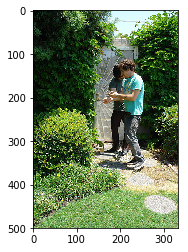

In [12]:
img=cv2.imread(imgbasedir+df.image_name.iloc[0])
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(df[' comment'].iloc[0])
print(img.shape)

In [0]:
imagesize=(299,299,3)

In [0]:
def fun1(df1):
    m=list(df1[" comment"].values)
    return m

In [0]:
df1=df.groupby(by='image_name').apply(fun1)

In [0]:
index1=df1.index
values=df1.values

In [0]:
dict1=dict([(index1[i],values[i]) for i in range(len(values))])

In [18]:
model=InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(299,299,3))

W0725 12:34:41.200108 140165865445248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 12:34:41.234967 140165865445248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 12:34:41.240590 140165865445248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 12:34:41.264893 140165865445248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0725 12:34:41.265872 1401658654

In [0]:
for layer in model.layers:
  layer.trainable=False
  
bottommodel=model.output
topmodel=GlobalAveragePooling2D()(bottommodel)
  

In [0]:
model1=Model(model.input,topmodel)

In [0]:
pred1=[]                          #due to memory constraints ,getting encodings in batches of 5000
for i in range(0,30000,5000):
    index2=index1[i:i+5000]
    xtrain=[]
    for i in range(len(index2)):
        img=cv2.imread(imgbasedir+index2[i])
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(299,299)).astype('float16')
        xtrain.append(img)
    xtrain=np.array(xtrain).astype('float16')/255
    pred=model1.predict(xtrain)
    pred1.append(pred)

In [0]:
xtrain=[]  # To Free up some Memory
pred=[]
pred2=np.vstack(pred1)


In [0]:
pred1=0

In [0]:
import random  #Getting the captioning text  for first 30000 images
tokendata=[random.sample(dict1[index1[i]],1)[0] for i in range(30000)]

In [0]:
Imgbottleneck=120
wordembedsize=32
rnnsize=256
ns=1536

In [0]:
import re

In [0]:
def fun(text):
    
    text=text.lower()
    text=re.sub(r"[^\w\d]"," ",text)
    text=re.sub(r"\s{2,}"," ",text)
    text=text.strip()
    return text


In [0]:
tokendata1=[fun(i) for i in tokendata]

In [0]:
tokendata1=np.array(tokendata1)

In [0]:
tokenizer=Tokenizer(num_words=3997,oov_token='<unk>')

In [0]:
tokenizer.fit_on_texts(tokendata1)

In [0]:
tokendata2=tokenizer.texts_to_sequences(tokendata1)

In [0]:
wordcount=tokenizer.word_counts

In [34]:
len([i for i,j in wordcount.items() if j>=4])

3874

In [0]:
word2index=tokenizer.word_index
word2index=dict([(i,j) for i,j in word2index.items() if j <=3997])
word2index['<pad>']=0
word2index['<start>']=len(word2index)
word2index['<end>']=len(word2index)

In [0]:
index2word=dict([(i,j) for j,i in word2index.items()])

In [0]:
tokendata3=[[word2index['<start>']]+tokendata2[i]+[word2index['<end>']] for i in range(len(tokendata2))]

In [0]:
length=[len(x) for x in tokendata3]

In [0]:
imgembedsize=1536
logitsbottleneck=200
ns=300
Imgbottleneck=128
wordembedsize=32


In [40]:
imgemb=tf.placeholder(shape=[None,1536],dtype=tf.float32)
sentences=tf.placeholder(shape=[None,None],dtype=tf.int32)
imgembed_bottleneck=tf.layers.dense(imgemb,Imgbottleneck,activation=tf.nn.relu,kernel_initializer=tf.random_normal_initializer)



W0725 12:49:11.407302 140165865445248 deprecation.py:323] From <ipython-input-40-6488d57e4801>:3: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


In [41]:
imgbottle_h=tf.layers.dense(imgembed_bottleneck,ns,activation=tf.nn.relu,kernel_initializer=tf.random_normal_initializer)
embedvar=tf.Variable(tf.random.normal([len(word2index),wordembedsize],0,1.0,dtype=tf.float32))
wordembed=tf.nn.embedding_lookup(embedvar,sentences[:,:-1])
lstm=tf.nn.rnn_cell.LSTMCell(ns,dtype=tf.float32)

W0725 12:49:11.938303 140165865445248 deprecation.py:323] From <ipython-input-41-3fdecbd87fc8>:4: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [0]:
c0=h0=imgbottle_h

In [0]:
seqlen=tf.placeholder(shape=[None],dtype=tf.int32)

In [44]:
hiddenstates,_=tf.nn.dynamic_rnn(lstm,wordembed,sequence_length=seqlen,initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0,h0),dtype=tf.float32)

W0725 12:49:11.970803 140165865445248 deprecation.py:323] From <ipython-input-44-b8ba668097c1>:1: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0725 12:49:12.061059 140165865445248 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0725 12:49:12.075099 140165865445248 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/rnn_cell_impl.py:961: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call init

In [45]:
hiddenstates.get_shape()


TensorShape([Dimension(None), Dimension(None), Dimension(300)])

In [0]:
tokenlogitsbottleneck=tf.layers.dense(hiddenstates,logitsbottleneck,activation=tf.nn.relu,kernel_initializer=tf.random_normal_initializer)

In [0]:
tokenlogits=tf.layers.dense(tokenlogitsbottleneck,len(word2index))

In [49]:
tokenlogits.get_shape()

TensorShape([Dimension(None), Dimension(None), Dimension(4000)])

In [0]:
len1=len(word2index)

In [0]:
finaltokenlogits=tf.reshape(tokenlogits,(-1,len1))

In [52]:
finaltokenlogits.get_shape()

TensorShape([Dimension(None), Dimension(4000)])

In [0]:
flatgroundtruth=tf.reshape(sentences[:,1:],[-1,])

In [0]:
flat_loss_mask = tf.not_equal(word2index['<pad>'],flatgroundtruth)

In [0]:
xent=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=finaltokenlogits,labels=flatgroundtruth)

In [0]:
loss=tf.reduce_mean(tf.boolean_mask(xent,flat_loss_mask))

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(loss)

In [0]:
saver = tf.train.Saver()

In [0]:
s=tf.InteractiveSession()

In [0]:
s.run(tf.global_variables_initializer())

In [80]:
len(length)

30000

(array([4.300e+01, 1.870e+02, 2.170e+03, 2.098e+03, 2.536e+03, 5.820e+03,
        2.751e+03, 2.539e+03, 4.095e+03, 1.585e+03, 1.244e+03, 1.786e+03,
        6.390e+02, 9.190e+02, 2.900e+02, 2.740e+02, 3.580e+02, 1.230e+02,
        8.500e+01, 1.530e+02, 5.900e+01, 5.000e+01, 5.700e+01, 2.400e+01,
        2.000e+01, 3.200e+01, 1.000e+01, 1.800e+01, 5.000e+00, 1.000e+01,
        5.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 4.  ,  5.36,  6.72,  8.08,  9.44, 10.8 , 12.16, 13.52, 14.88,
        16.24, 17.6 , 18.96, 20.32, 21.68, 23.04, 24.4 , 25.76, 27.12,
        28.48, 29.84, 31.2 , 32.56, 33.92, 35.28, 36.64, 38.  , 39.36,
        40.72, 42.08, 43.44, 44.8 , 46.16, 47.52, 48.88, 50.24, 51.6 ,
        52.96, 54.32, 55.68, 57.04, 58.4 , 59.76, 61.12, 62.48, 63.84,
        65.2 , 66.56,

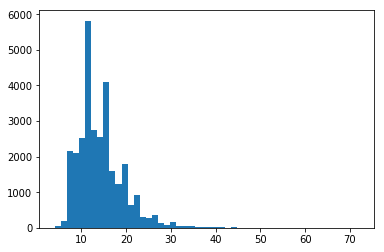

In [78]:
plt.hist(length,bins=50)

In [0]:
def generate_batch(images_embeddings, indexed_captions,lengths,batch_size, max_len=None):
    
    if batch_size==None:
      batch_size=len(images_embeddings)
    m=np.random.choice(len(images_embeddings),size=batch_size,replace=False)
    batchcaptions =indexed_captions[m] 
    batch_image_embeddings = images_embeddings[m]
    len1=lengths[m]
    batch_captions_matrix=pad_sequences(batchcaptions,maxlen=max_len,padding='post')
    
    
    return (batch_image_embeddings, 
            batch_captions_matrix,len1)

In [0]:
batch_size = 64
n_epochs = 10
n_batches_per_epoch = 1000
n_validation_batches = 100

In [88]:
generate_batch(pred2,np.array(tokendata3),np.array(length),64,None)[1].shape

(64, 40)

In [0]:
#Creating Training ,Validation datasets
trainlabels,validlabels=train_test_split(np.arange(30000),test_size=0.01)

In [0]:
trainXdata=pred2[trainlabels]
trainYdata=np.array(tokendata3)[trainlabels]
trainlength=np.array(length)[trainlabels]
validXdata=pred2[validlabels]
validYdata=np.array(tokendata3)[validlabels]
validlength=np.array(length)[validlabels]

In [120]:
validXdata.shape

(300, 1536)

In [122]:
trainloss=[]
count=0
validloss=[]
for i in range(n_epochs):
  for j in tqdm(range(n_batches_per_epoch)):
    batchx,batchy,batchlen=generate_batch(trainXdata,trainYdata,trainlength,64,None)
    loss1,_=s.run([loss,train_step],feed_dict={imgemb:batchx,sentences:batchy,seqlen:batchlen})
    
    if count%50==0:
      #print("-----trainloss:-",loss1," count:-",count)
      batchx,batchy,batchlen=generate_batch(validXdata,validYdata,validlength,None,None)
      validloss1=s.run(loss,feed_dict={imgemb:batchx,sentences:batchy,seqlen:batchlen})
      print("-----validloss:-",validloss1,"---trainloss:-",loss1,"  count:-",count)
      validloss.append(validloss1)
    count+=1
    trainloss.append(loss1)

  0%|          | 5/1000 [00:00<01:05, 15.10it/s]

-----validloss:- 8.233302 ---trainloss:- 9.030429   count:- 0


  6%|▌         | 56/1000 [00:02<00:38, 24.58it/s]

-----validloss:- 5.006722 ---trainloss:- 5.106099   count:- 50


 10%|█         | 104/1000 [00:04<00:36, 24.38it/s]

-----validloss:- 4.6725645 ---trainloss:- 4.310619   count:- 100


 15%|█▌        | 152/1000 [00:06<00:36, 23.43it/s]

-----validloss:- 4.44724 ---trainloss:- 4.5148335   count:- 150


 20%|██        | 204/1000 [00:07<00:28, 28.40it/s]

-----validloss:- 4.320466 ---trainloss:- 4.068456   count:- 200


 26%|██▌       | 255/1000 [00:09<00:29, 25.09it/s]

-----validloss:- 4.2141557 ---trainloss:- 4.3559895   count:- 250


 30%|███       | 305/1000 [00:11<00:25, 27.04it/s]

-----validloss:- 4.1163564 ---trainloss:- 4.2604284   count:- 300


 35%|███▌      | 353/1000 [00:13<00:25, 25.05it/s]

-----validloss:- 4.050816 ---trainloss:- 3.9676125   count:- 350


 40%|████      | 403/1000 [00:15<00:24, 24.25it/s]

-----validloss:- 3.9906116 ---trainloss:- 3.9444263   count:- 400


 46%|████▌     | 455/1000 [00:17<00:21, 25.42it/s]

-----validloss:- 3.9599452 ---trainloss:- 3.7329216   count:- 450


 50%|█████     | 505/1000 [00:19<00:18, 26.09it/s]

-----validloss:- 3.9072888 ---trainloss:- 3.7269318   count:- 500


 55%|█████▌    | 554/1000 [00:20<00:18, 24.04it/s]

-----validloss:- 3.8641546 ---trainloss:- 3.665889   count:- 550


 60%|██████    | 604/1000 [00:22<00:14, 28.23it/s]

-----validloss:- 3.8246644 ---trainloss:- 3.7862837   count:- 600


 66%|██████▌   | 655/1000 [00:24<00:13, 26.01it/s]

-----validloss:- 3.7951832 ---trainloss:- 3.6037517   count:- 650


 71%|███████   | 707/1000 [00:26<00:11, 25.81it/s]

-----validloss:- 3.7831838 ---trainloss:- 3.6048222   count:- 700


 76%|███████▌  | 756/1000 [00:28<00:09, 25.95it/s]

-----validloss:- 3.7615669 ---trainloss:- 3.6884475   count:- 750


 80%|████████  | 805/1000 [00:29<00:07, 27.79it/s]

-----validloss:- 3.744918 ---trainloss:- 3.448249   count:- 800


 86%|████████▌ | 856/1000 [00:31<00:05, 27.13it/s]

-----validloss:- 3.7318022 ---trainloss:- 3.2661107   count:- 850


 90%|█████████ | 904/1000 [00:33<00:03, 27.15it/s]

-----validloss:- 3.7243993 ---trainloss:- 3.4207456   count:- 900


 96%|█████████▌| 955/1000 [00:35<00:01, 29.44it/s]

-----validloss:- 3.7188625 ---trainloss:- 3.3245351   count:- 950


  1%|          | 6/1000 [00:00<00:44, 22.29it/s]

-----validloss:- 3.7065198 ---trainloss:- 3.4220076   count:- 1000


  6%|▌         | 55/1000 [00:01<00:35, 26.31it/s]

-----validloss:- 3.686117 ---trainloss:- 3.2847793   count:- 1050


 10%|█         | 103/1000 [00:03<00:36, 24.74it/s]

-----validloss:- 3.6742318 ---trainloss:- 3.382628   count:- 1100


 15%|█▌        | 154/1000 [00:05<00:30, 27.35it/s]

-----validloss:- 3.6661432 ---trainloss:- 3.0931833   count:- 1150


 20%|██        | 205/1000 [00:07<00:34, 23.32it/s]

-----validloss:- 3.6717916 ---trainloss:- 3.1131434   count:- 1200


 25%|██▌       | 254/1000 [00:09<00:29, 25.10it/s]

-----validloss:- 3.647699 ---trainloss:- 3.1495042   count:- 1250


 30%|███       | 304/1000 [00:11<00:25, 27.25it/s]

-----validloss:- 3.6323998 ---trainloss:- 3.2175982   count:- 1300


 35%|███▌      | 353/1000 [00:13<00:26, 24.03it/s]

-----validloss:- 3.6482248 ---trainloss:- 2.9916215   count:- 1350


 41%|████      | 406/1000 [00:14<00:21, 27.71it/s]

-----validloss:- 3.6382873 ---trainloss:- 3.1987793   count:- 1400


 46%|████▌     | 457/1000 [00:16<00:20, 26.96it/s]

-----validloss:- 3.655769 ---trainloss:- 3.0533445   count:- 1450


 50%|█████     | 503/1000 [00:18<00:19, 25.83it/s]

-----validloss:- 3.652768 ---trainloss:- 3.037058   count:- 1500


 55%|█████▌    | 554/1000 [00:20<00:17, 26.03it/s]

-----validloss:- 3.6513119 ---trainloss:- 2.9600205   count:- 1550


 61%|██████    | 606/1000 [00:22<00:16, 23.41it/s]

-----validloss:- 3.6550694 ---trainloss:- 3.2483237   count:- 1600


 65%|██████▌   | 654/1000 [00:24<00:13, 26.05it/s]

-----validloss:- 3.6570523 ---trainloss:- 3.0413668   count:- 1650


 70%|███████   | 705/1000 [00:26<00:11, 25.64it/s]

-----validloss:- 3.6351764 ---trainloss:- 2.9637544   count:- 1700


 76%|███████▌  | 757/1000 [00:28<00:09, 26.08it/s]

-----validloss:- 3.646061 ---trainloss:- 2.9849265   count:- 1750


 81%|████████  | 806/1000 [00:29<00:07, 26.97it/s]

-----validloss:- 3.6682205 ---trainloss:- 3.0558639   count:- 1800


 85%|████████▌ | 853/1000 [00:31<00:06, 24.36it/s]

-----validloss:- 3.6515272 ---trainloss:- 2.9029918   count:- 1850


 90%|█████████ | 904/1000 [00:33<00:04, 22.89it/s]

-----validloss:- 3.635407 ---trainloss:- 2.9742525   count:- 1900


 95%|█████████▌| 954/1000 [00:35<00:01, 26.42it/s]

-----validloss:- 3.6375043 ---trainloss:- 2.9873579   count:- 1950


  0%|          | 5/1000 [00:00<00:56, 17.73it/s]

-----validloss:- 3.649504 ---trainloss:- 2.915207   count:- 2000


  5%|▌         | 54/1000 [00:02<00:35, 26.88it/s]

-----validloss:- 3.644146 ---trainloss:- 2.7615411   count:- 2050


 11%|█         | 106/1000 [00:04<00:34, 25.85it/s]

-----validloss:- 3.6533172 ---trainloss:- 2.9467332   count:- 2100


 15%|█▌        | 154/1000 [00:05<00:32, 25.71it/s]

-----validloss:- 3.657581 ---trainloss:- 2.9092522   count:- 2150


 20%|██        | 204/1000 [00:07<00:29, 26.68it/s]

-----validloss:- 3.663009 ---trainloss:- 3.0366657   count:- 2200


 26%|██▌       | 255/1000 [00:09<00:31, 23.75it/s]

-----validloss:- 3.658822 ---trainloss:- 2.6867373   count:- 2250


 30%|███       | 305/1000 [00:11<00:27, 24.86it/s]

-----validloss:- 3.659744 ---trainloss:- 2.7470908   count:- 2300


 35%|███▌      | 354/1000 [00:12<00:22, 28.18it/s]

-----validloss:- 3.6576872 ---trainloss:- 2.9174027   count:- 2350


 40%|████      | 405/1000 [00:14<00:22, 26.98it/s]

-----validloss:- 3.65104 ---trainloss:- 2.8671093   count:- 2400


 45%|████▌     | 454/1000 [00:16<00:20, 26.67it/s]

-----validloss:- 3.6708708 ---trainloss:- 2.9802465   count:- 2450


 50%|█████     | 503/1000 [00:18<00:22, 21.78it/s]

-----validloss:- 3.6682875 ---trainloss:- 2.754257   count:- 2500


 56%|█████▌    | 555/1000 [00:20<00:17, 25.56it/s]

-----validloss:- 3.6690419 ---trainloss:- 2.8673718   count:- 2550


 61%|██████    | 606/1000 [00:22<00:15, 24.99it/s]

-----validloss:- 3.6912973 ---trainloss:- 2.8494391   count:- 2600


 66%|██████▌   | 655/1000 [00:24<00:15, 22.68it/s]

-----validloss:- 3.684203 ---trainloss:- 2.7262816   count:- 2650


 71%|███████   | 706/1000 [00:26<00:11, 26.07it/s]

-----validloss:- 3.681252 ---trainloss:- 2.854875   count:- 2700


 75%|███████▌  | 754/1000 [00:27<00:09, 26.59it/s]

-----validloss:- 3.6872895 ---trainloss:- 2.765485   count:- 2750


 80%|████████  | 805/1000 [00:29<00:07, 27.10it/s]

-----validloss:- 3.6802309 ---trainloss:- 2.765546   count:- 2800


 85%|████████▌ | 854/1000 [00:31<00:05, 24.92it/s]

-----validloss:- 3.6969848 ---trainloss:- 2.732733   count:- 2850


 90%|█████████ | 905/1000 [00:33<00:03, 26.77it/s]

-----validloss:- 3.7248087 ---trainloss:- 2.7295403   count:- 2900


 96%|█████████▌| 956/1000 [00:35<00:01, 24.99it/s]

-----validloss:- 3.721637 ---trainloss:- 2.6793866   count:- 2950


  0%|          | 5/1000 [00:00<00:54, 18.25it/s]

-----validloss:- 3.7318637 ---trainloss:- 2.5883772   count:- 3000


  6%|▌         | 57/1000 [00:02<00:33, 27.76it/s]

-----validloss:- 3.7151823 ---trainloss:- 2.8493545   count:- 3050


 11%|█         | 106/1000 [00:03<00:34, 25.99it/s]

-----validloss:- 3.7135699 ---trainloss:- 2.8396108   count:- 3100


 16%|█▌        | 155/1000 [00:05<00:33, 25.12it/s]

-----validloss:- 3.744735 ---trainloss:- 2.6586165   count:- 3150


 20%|██        | 205/1000 [00:07<00:28, 27.75it/s]

-----validloss:- 3.7363422 ---trainloss:- 2.607244   count:- 3200


 26%|██▌       | 255/1000 [00:09<00:29, 24.90it/s]

-----validloss:- 3.7492929 ---trainloss:- 2.5918183   count:- 3250


 31%|███       | 306/1000 [00:11<00:26, 25.98it/s]

-----validloss:- 3.7670567 ---trainloss:- 2.6404433   count:- 3300


 36%|███▌      | 355/1000 [00:13<00:24, 26.12it/s]

-----validloss:- 3.760482 ---trainloss:- 2.6663902   count:- 3350


 41%|████      | 406/1000 [00:14<00:23, 25.23it/s]

-----validloss:- 3.7731054 ---trainloss:- 2.6686976   count:- 3400


 46%|████▌     | 455/1000 [00:16<00:21, 25.85it/s]

-----validloss:- 3.7589557 ---trainloss:- 2.6162446   count:- 3450


 51%|█████     | 506/1000 [00:18<00:18, 26.39it/s]

-----validloss:- 3.7747288 ---trainloss:- 2.570845   count:- 3500


 56%|█████▌    | 555/1000 [00:20<00:16, 26.51it/s]

-----validloss:- 3.769495 ---trainloss:- 2.478827   count:- 3550


 60%|██████    | 605/1000 [00:22<00:14, 27.01it/s]

-----validloss:- 3.7823296 ---trainloss:- 2.5037425   count:- 3600


 65%|██████▌   | 654/1000 [00:23<00:14, 24.38it/s]

-----validloss:- 3.7909808 ---trainloss:- 2.6266522   count:- 3650


 70%|███████   | 704/1000 [00:25<00:10, 28.19it/s]

-----validloss:- 3.80754 ---trainloss:- 2.5768542   count:- 3700


 76%|███████▌  | 757/1000 [00:27<00:08, 27.45it/s]

-----validloss:- 3.819646 ---trainloss:- 2.6174629   count:- 3750


 80%|████████  | 805/1000 [00:29<00:07, 26.01it/s]

-----validloss:- 3.83205 ---trainloss:- 2.5284002   count:- 3800


 86%|████████▌ | 855/1000 [00:31<00:05, 25.40it/s]

-----validloss:- 3.8196924 ---trainloss:- 2.4498703   count:- 3850


 91%|█████████ | 907/1000 [00:32<00:03, 27.47it/s]

-----validloss:- 3.8177478 ---trainloss:- 2.4849513   count:- 3900


 95%|█████████▌| 954/1000 [00:34<00:01, 27.80it/s]

-----validloss:- 3.838527 ---trainloss:- 2.5981138   count:- 3950


  0%|          | 5/1000 [00:00<00:54, 18.36it/s]

-----validloss:- 3.8626513 ---trainloss:- 2.4354188   count:- 4000


  6%|▌         | 56/1000 [00:02<00:36, 26.13it/s]

-----validloss:- 3.8615751 ---trainloss:- 2.3141603   count:- 4050


 11%|█         | 106/1000 [00:04<00:35, 24.86it/s]

-----validloss:- 3.8648233 ---trainloss:- 2.4313374   count:- 4100


 15%|█▌        | 154/1000 [00:05<00:31, 27.15it/s]

-----validloss:- 3.8722837 ---trainloss:- 2.4301033   count:- 4150


 20%|██        | 204/1000 [00:07<00:28, 28.17it/s]

-----validloss:- 3.8746202 ---trainloss:- 2.4683664   count:- 4200


 26%|██▌       | 256/1000 [00:09<00:28, 26.43it/s]

-----validloss:- 3.8834784 ---trainloss:- 2.5774662   count:- 4250


 30%|███       | 305/1000 [00:11<00:29, 23.85it/s]

-----validloss:- 3.890354 ---trainloss:- 2.422305   count:- 4300


 36%|███▌      | 356/1000 [00:13<00:25, 25.23it/s]

-----validloss:- 3.8754585 ---trainloss:- 2.3289454   count:- 4350


 40%|████      | 405/1000 [00:14<00:21, 27.51it/s]

-----validloss:- 3.8782785 ---trainloss:- 2.4561853   count:- 4400


 46%|████▌     | 456/1000 [00:16<00:20, 26.40it/s]

-----validloss:- 3.89958 ---trainloss:- 2.380674   count:- 4450


 50%|█████     | 505/1000 [00:18<00:18, 27.30it/s]

-----validloss:- 3.9109664 ---trainloss:- 2.5013444   count:- 4500


 56%|█████▌    | 555/1000 [00:20<00:17, 25.19it/s]

-----validloss:- 3.901641 ---trainloss:- 2.5216067   count:- 4550


 61%|██████    | 607/1000 [00:22<00:14, 27.82it/s]

-----validloss:- 3.9242299 ---trainloss:- 2.3878043   count:- 4600


 66%|██████▌   | 657/1000 [00:24<00:12, 27.59it/s]

-----validloss:- 3.9534771 ---trainloss:- 2.4506776   count:- 4650


 70%|███████   | 703/1000 [00:25<00:11, 24.97it/s]

-----validloss:- 3.9638224 ---trainloss:- 2.3716862   count:- 4700


 76%|███████▌  | 755/1000 [00:27<00:09, 24.96it/s]

-----validloss:- 3.9638236 ---trainloss:- 2.4160948   count:- 4750


 80%|████████  | 805/1000 [00:29<00:06, 27.98it/s]

-----validloss:- 3.9698632 ---trainloss:- 2.3962603   count:- 4800


 85%|████████▌ | 854/1000 [00:31<00:05, 27.02it/s]

-----validloss:- 3.98943 ---trainloss:- 2.2544057   count:- 4850


 90%|█████████ | 904/1000 [00:33<00:03, 25.38it/s]

-----validloss:- 3.9743576 ---trainloss:- 2.3528821   count:- 4900


 96%|█████████▌| 955/1000 [00:35<00:01, 27.94it/s]

-----validloss:- 3.9526381 ---trainloss:- 2.2702818   count:- 4950


  0%|          | 4/1000 [00:00<01:33, 10.68it/s]

-----validloss:- 3.9920075 ---trainloss:- 2.5097566   count:- 5000


  6%|▌         | 55/1000 [00:02<00:35, 26.61it/s]

-----validloss:- 4.010856 ---trainloss:- 2.2727442   count:- 5050


 10%|█         | 105/1000 [00:03<00:35, 25.51it/s]

-----validloss:- 3.9860954 ---trainloss:- 2.2647243   count:- 5100


 16%|█▌        | 157/1000 [00:05<00:30, 28.03it/s]

-----validloss:- 3.9833522 ---trainloss:- 2.2724655   count:- 5150


 21%|██        | 206/1000 [00:07<00:30, 26.05it/s]

-----validloss:- 4.0077744 ---trainloss:- 2.2557468   count:- 5200


 26%|██▌       | 256/1000 [00:09<00:29, 25.14it/s]

-----validloss:- 4.0419803 ---trainloss:- 2.3087285   count:- 5250


 30%|███       | 305/1000 [00:11<00:24, 28.12it/s]

-----validloss:- 4.0059414 ---trainloss:- 2.2932622   count:- 5300


 36%|███▌      | 355/1000 [00:12<00:25, 25.74it/s]

-----validloss:- 4.0316253 ---trainloss:- 2.0854967   count:- 5350


 40%|████      | 403/1000 [00:14<00:23, 24.94it/s]

-----validloss:- 4.037107 ---trainloss:- 2.2606769   count:- 5400


 46%|████▌     | 455/1000 [00:16<00:19, 27.71it/s]

-----validloss:- 4.0648875 ---trainloss:- 2.3232052   count:- 5450


 50%|█████     | 504/1000 [00:18<00:18, 27.50it/s]

-----validloss:- 4.0919967 ---trainloss:- 2.3499553   count:- 5500


 56%|█████▌    | 556/1000 [00:20<00:16, 26.13it/s]

-----validloss:- 4.085001 ---trainloss:- 2.2110636   count:- 5550


 60%|██████    | 604/1000 [00:22<00:15, 25.49it/s]

-----validloss:- 4.078393 ---trainloss:- 2.3931618   count:- 5600


 65%|██████▌   | 654/1000 [00:23<00:13, 25.25it/s]

-----validloss:- 4.1175714 ---trainloss:- 2.3355658   count:- 5650


 71%|███████   | 707/1000 [00:25<00:10, 27.31it/s]

-----validloss:- 4.130241 ---trainloss:- 2.2129102   count:- 5700


 76%|███████▌  | 756/1000 [00:27<00:09, 26.35it/s]

-----validloss:- 4.119966 ---trainloss:- 2.2439702   count:- 5750


 81%|████████  | 806/1000 [00:29<00:07, 24.49it/s]

-----validloss:- 4.1442966 ---trainloss:- 2.1694217   count:- 5800


 86%|████████▌ | 855/1000 [00:31<00:05, 27.28it/s]

-----validloss:- 4.157123 ---trainloss:- 2.1988025   count:- 5850


 90%|█████████ | 904/1000 [00:33<00:03, 26.09it/s]

-----validloss:- 4.1239953 ---trainloss:- 2.1586776   count:- 5900


 95%|█████████▌| 954/1000 [00:35<00:01, 25.45it/s]

-----validloss:- 4.136142 ---trainloss:- 2.2087576   count:- 5950


  1%|          | 6/1000 [00:00<00:46, 21.60it/s]

-----validloss:- 4.179814 ---trainloss:- 2.297649   count:- 6000


  5%|▌         | 53/1000 [00:01<00:39, 24.06it/s]

-----validloss:- 4.145325 ---trainloss:- 2.2761493   count:- 6050


 10%|█         | 105/1000 [00:03<00:31, 28.01it/s]

-----validloss:- 4.1885605 ---trainloss:- 2.2436166   count:- 6100


 16%|█▌        | 155/1000 [00:05<00:33, 25.56it/s]

-----validloss:- 4.178554 ---trainloss:- 2.1574676   count:- 6150


 21%|██        | 206/1000 [00:07<00:30, 25.70it/s]

-----validloss:- 4.196874 ---trainloss:- 2.1546476   count:- 6200


 26%|██▌       | 256/1000 [00:09<00:28, 26.27it/s]

-----validloss:- 4.2208304 ---trainloss:- 2.237375   count:- 6250


 30%|███       | 304/1000 [00:10<00:25, 27.61it/s]

-----validloss:- 4.2098875 ---trainloss:- 2.456581   count:- 6300


 36%|███▌      | 355/1000 [00:12<00:27, 23.39it/s]

-----validloss:- 4.228086 ---trainloss:- 2.0780277   count:- 6350


 40%|████      | 404/1000 [00:14<00:24, 24.65it/s]

-----validloss:- 4.233635 ---trainloss:- 2.2780437   count:- 6400


 46%|████▌     | 457/1000 [00:16<00:19, 28.44it/s]

-----validloss:- 4.2789154 ---trainloss:- 2.094073   count:- 6450


 51%|█████     | 506/1000 [00:18<00:17, 27.52it/s]

-----validloss:- 4.2307115 ---trainloss:- 2.0360951   count:- 6500


 56%|█████▌    | 555/1000 [00:19<00:16, 26.81it/s]

-----validloss:- 4.268923 ---trainloss:- 2.1552663   count:- 6550


 60%|██████    | 603/1000 [00:21<00:15, 25.96it/s]

-----validloss:- 4.269474 ---trainloss:- 2.1036768   count:- 6600


 65%|██████▌   | 654/1000 [00:23<00:12, 26.66it/s]

-----validloss:- 4.2922587 ---trainloss:- 2.168139   count:- 6650


 70%|███████   | 705/1000 [00:25<00:11, 26.16it/s]

-----validloss:- 4.284079 ---trainloss:- 2.274375   count:- 6700


 75%|███████▌  | 754/1000 [00:27<00:09, 27.03it/s]

-----validloss:- 4.272914 ---trainloss:- 2.1967454   count:- 6750


 80%|████████  | 804/1000 [00:28<00:07, 25.75it/s]

-----validloss:- 4.2805266 ---trainloss:- 2.1522598   count:- 6800


 86%|████████▌ | 855/1000 [00:30<00:05, 28.23it/s]

-----validloss:- 4.3077493 ---trainloss:- 2.2037044   count:- 6850


 90%|█████████ | 902/1000 [00:32<00:03, 24.63it/s]

-----validloss:- 4.309056 ---trainloss:- 2.1474912   count:- 6900


 96%|█████████▌| 955/1000 [00:34<00:01, 26.72it/s]

-----validloss:- 4.353704 ---trainloss:- 2.0797193   count:- 6950


  0%|          | 5/1000 [00:00<00:48, 20.47it/s]

-----validloss:- 4.329723 ---trainloss:- 2.0391119   count:- 7000


  5%|▌         | 54/1000 [00:02<00:36, 26.24it/s]

-----validloss:- 4.3651233 ---trainloss:- 2.2056835   count:- 7050


 10%|█         | 105/1000 [00:04<00:35, 25.03it/s]

-----validloss:- 4.369667 ---trainloss:- 2.0627177   count:- 7100


 15%|█▌        | 154/1000 [00:05<00:30, 27.31it/s]

-----validloss:- 4.3506966 ---trainloss:- 2.0479608   count:- 7150


 21%|██        | 206/1000 [00:07<00:31, 25.21it/s]

-----validloss:- 4.395123 ---trainloss:- 2.1254802   count:- 7200


 26%|██▌       | 256/1000 [00:09<00:29, 25.19it/s]

-----validloss:- 4.396691 ---trainloss:- 2.0340478   count:- 7250


 30%|███       | 305/1000 [00:11<00:26, 26.39it/s]

-----validloss:- 4.420777 ---trainloss:- 2.1541317   count:- 7300


 35%|███▌      | 354/1000 [00:13<00:25, 25.50it/s]

-----validloss:- 4.384608 ---trainloss:- 2.1187863   count:- 7350


 40%|████      | 404/1000 [00:15<00:23, 24.84it/s]

-----validloss:- 4.4054494 ---trainloss:- 2.069343   count:- 7400


 45%|████▌     | 454/1000 [00:17<00:20, 26.72it/s]

-----validloss:- 4.3982334 ---trainloss:- 2.0438707   count:- 7450


 51%|█████     | 506/1000 [00:18<00:19, 25.80it/s]

-----validloss:- 4.4271917 ---trainloss:- 2.1208432   count:- 7500


 56%|█████▌    | 555/1000 [00:20<00:17, 25.28it/s]

-----validloss:- 4.4331064 ---trainloss:- 2.104762   count:- 7550


 60%|██████    | 605/1000 [00:22<00:15, 26.13it/s]

-----validloss:- 4.455199 ---trainloss:- 2.201079   count:- 7600


 66%|██████▌   | 655/1000 [00:24<00:11, 28.93it/s]

-----validloss:- 4.4344835 ---trainloss:- 1.9518118   count:- 7650


 70%|███████   | 703/1000 [00:26<00:11, 25.40it/s]

-----validloss:- 4.4344935 ---trainloss:- 2.0419986   count:- 7700


 76%|███████▌  | 756/1000 [00:28<00:08, 27.20it/s]

-----validloss:- 4.4804893 ---trainloss:- 1.9664626   count:- 7750


 80%|████████  | 805/1000 [00:29<00:07, 26.30it/s]

-----validloss:- 4.4604473 ---trainloss:- 1.9296789   count:- 7800


 86%|████████▌ | 855/1000 [00:31<00:05, 25.49it/s]

-----validloss:- 4.5189047 ---trainloss:- 1.8692247   count:- 7850


 91%|█████████ | 907/1000 [00:33<00:03, 27.14it/s]

-----validloss:- 4.5140777 ---trainloss:- 1.876715   count:- 7900


 96%|█████████▌| 955/1000 [00:35<00:01, 25.40it/s]

-----validloss:- 4.560042 ---trainloss:- 2.019598   count:- 7950


  1%|          | 6/1000 [00:00<00:41, 23.69it/s]

-----validloss:- 4.55262 ---trainloss:- 2.1408393   count:- 8000


  5%|▌         | 54/1000 [00:01<00:34, 27.66it/s]

-----validloss:- 4.5259852 ---trainloss:- 2.0730834   count:- 8050


 11%|█         | 106/1000 [00:03<00:34, 26.01it/s]

-----validloss:- 4.5268383 ---trainloss:- 1.9672259   count:- 8100


 16%|█▌        | 156/1000 [00:05<00:32, 25.84it/s]

-----validloss:- 4.5676737 ---trainloss:- 1.9700443   count:- 8150


 21%|██        | 206/1000 [00:07<00:31, 24.82it/s]

-----validloss:- 4.5581155 ---trainloss:- 1.8447686   count:- 8200


 26%|██▌       | 255/1000 [00:09<00:31, 23.44it/s]

-----validloss:- 4.561714 ---trainloss:- 2.145631   count:- 8250


 30%|███       | 304/1000 [00:11<00:26, 26.03it/s]

-----validloss:- 4.5905333 ---trainloss:- 2.0183153   count:- 8300


 35%|███▌      | 354/1000 [00:12<00:26, 24.57it/s]

-----validloss:- 4.6013193 ---trainloss:- 2.0278277   count:- 8350


 40%|████      | 405/1000 [00:14<00:23, 25.29it/s]

-----validloss:- 4.624423 ---trainloss:- 2.038264   count:- 8400


 46%|████▌     | 455/1000 [00:16<00:23, 23.29it/s]

-----validloss:- 4.5926385 ---trainloss:- 1.8947718   count:- 8450


 50%|█████     | 504/1000 [00:18<00:17, 27.81it/s]

-----validloss:- 4.6179132 ---trainloss:- 2.0308442   count:- 8500


 56%|█████▌    | 556/1000 [00:20<00:16, 26.34it/s]

-----validloss:- 4.65182 ---trainloss:- 1.9531999   count:- 8550


 61%|██████    | 606/1000 [00:22<00:14, 27.08it/s]

-----validloss:- 4.6500845 ---trainloss:- 1.8185806   count:- 8600


 66%|██████▌   | 655/1000 [00:23<00:12, 26.60it/s]

-----validloss:- 4.638272 ---trainloss:- 1.9898987   count:- 8650


 70%|███████   | 705/1000 [00:25<00:11, 26.42it/s]

-----validloss:- 4.6195235 ---trainloss:- 1.9180042   count:- 8700


 75%|███████▌  | 754/1000 [00:27<00:10, 24.21it/s]

-----validloss:- 4.6699266 ---trainloss:- 1.9985389   count:- 8750


 80%|████████  | 803/1000 [00:29<00:08, 24.52it/s]

-----validloss:- 4.709851 ---trainloss:- 1.9101954   count:- 8800


 86%|████████▌ | 855/1000 [00:31<00:05, 27.64it/s]

-----validloss:- 4.682078 ---trainloss:- 2.1054049   count:- 8850


 90%|█████████ | 905/1000 [00:33<00:03, 25.78it/s]

-----validloss:- 4.7107463 ---trainloss:- 2.035768   count:- 8900


 96%|█████████▌| 956/1000 [00:35<00:01, 27.81it/s]

-----validloss:- 4.699506 ---trainloss:- 1.9775923   count:- 8950


  1%|          | 6/1000 [00:00<00:38, 25.94it/s]

-----validloss:- 4.709339 ---trainloss:- 1.8672631   count:- 9000


  6%|▌         | 57/1000 [00:02<00:34, 27.62it/s]

-----validloss:- 4.7162943 ---trainloss:- 1.8555038   count:- 9050


 10%|█         | 104/1000 [00:03<00:35, 25.21it/s]

-----validloss:- 4.727693 ---trainloss:- 1.830123   count:- 9100


 15%|█▌        | 154/1000 [00:05<00:29, 28.86it/s]

-----validloss:- 4.7804995 ---trainloss:- 1.8217294   count:- 9150


 20%|██        | 204/1000 [00:07<00:29, 26.55it/s]

-----validloss:- 4.775863 ---trainloss:- 1.8872992   count:- 9200


 26%|██▌       | 256/1000 [00:09<00:26, 28.37it/s]

-----validloss:- 4.7839103 ---trainloss:- 1.824515   count:- 9250


 30%|███       | 304/1000 [00:11<00:31, 21.92it/s]

-----validloss:- 4.780521 ---trainloss:- 1.8277133   count:- 9300


 36%|███▌      | 357/1000 [00:12<00:23, 27.09it/s]

-----validloss:- 4.810224 ---trainloss:- 1.8286083   count:- 9350


 40%|████      | 404/1000 [00:14<00:20, 28.60it/s]

-----validloss:- 4.8144875 ---trainloss:- 1.8802104   count:- 9400


 46%|████▌     | 456/1000 [00:16<00:19, 27.27it/s]

-----validloss:- 4.8127093 ---trainloss:- 1.9650735   count:- 9450


 51%|█████     | 506/1000 [00:18<00:19, 25.49it/s]

-----validloss:- 4.8283587 ---trainloss:- 1.8141353   count:- 9500


 56%|█████▌    | 556/1000 [00:20<00:16, 26.95it/s]

-----validloss:- 4.8450923 ---trainloss:- 1.8431603   count:- 9550


 61%|██████    | 606/1000 [00:21<00:15, 25.88it/s]

-----validloss:- 4.8617587 ---trainloss:- 1.722365   count:- 9600


 66%|██████▌   | 655/1000 [00:23<00:13, 25.64it/s]

-----validloss:- 4.8963265 ---trainloss:- 1.8886603   count:- 9650


 71%|███████   | 707/1000 [00:25<00:10, 27.41it/s]

-----validloss:- 4.877239 ---trainloss:- 1.8789693   count:- 9700


 75%|███████▌  | 754/1000 [00:27<00:09, 25.60it/s]

-----validloss:- 4.883884 ---trainloss:- 1.6823485   count:- 9750


 80%|████████  | 805/1000 [00:29<00:07, 25.95it/s]

-----validloss:- 4.9130983 ---trainloss:- 1.8810904   count:- 9800


 85%|████████▌ | 854/1000 [00:31<00:06, 24.30it/s]

-----validloss:- 4.867983 ---trainloss:- 1.8489381   count:- 9850


 90%|█████████ | 905/1000 [00:33<00:03, 25.81it/s]

-----validloss:- 4.94094 ---trainloss:- 1.7665498   count:- 9900


 95%|█████████▌| 953/1000 [00:34<00:01, 25.78it/s]

-----validloss:- 4.943397 ---trainloss:- 1.697985   count:- 9950


100%|██████████| 1000/1000 [00:36<00:00, 27.26it/s]


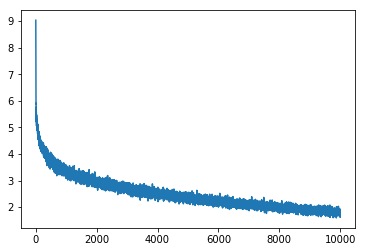

In [123]:
plt.plot(trainloss)

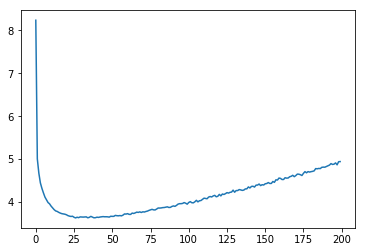

In [124]:
plt.plot(validloss)